In [28]:
%pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers,models
from matplotlib import pyplot as plt

In [30]:
IMAGE_SIZE=255
BATCH_SIZE=40
EPOCHS=20
CHANNELS=3 #RGB 


In [31]:
dataset= tf.keras.preprocessing.image_dataset_from_directory("training_data/tomato_disease_category", shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 6271 files belonging to 4 classes.


In [32]:
print(dataset.class_names)
print(len(dataset.class_names))

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy']
4


In [33]:
print(len(dataset))

157


In [34]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    # 1 - 7 because we have 7 classes of tomato diseases
    print(label_batch.numpy()) #numpy() is used to convert tensor to numpy array


[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[1 1 0 3 1 0 1 1 2 1 3 2 1 0 2 3 2 2 3 2 0 0 2 2 3 3 3 2 1 1 2 1 3 3 1 3 1
 3 2 2]


2024-07-07 20:16:02.783323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [35]:
class_names=dataset.class_names
print(class_names)

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy']


2024-07-07 20:16:02.844542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


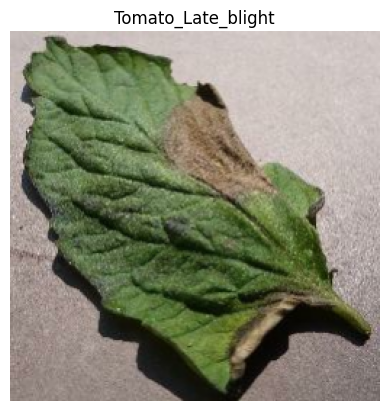

In [36]:
for image_batch,label_batch in dataset.take(1):
    plt.axis("off")
    plt.title(class_names[label_batch[0]])
    plt.imshow(image_batch[0].numpy().astype("uint8"))


2024-07-07 20:16:03.219334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


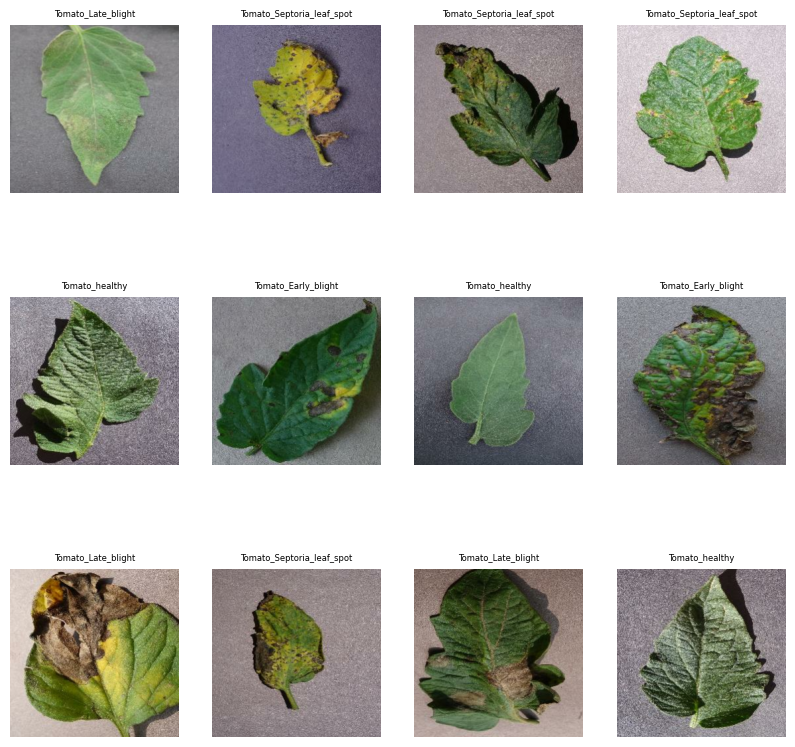

In [37]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]], fontsize=6)
        plt.axis("off")

        

In [38]:
# 80% => training
# 20% => validation, testing

In [39]:
train_size=0.8
train_size=int(train_size*len(dataset))
print(train_size)


125


In [40]:
train_ds=dataset.take(train_size)
len(train_ds)


125

In [41]:
test_ds=dataset.skip(train_size)
len(test_ds)

32

In [42]:
val_size=0.1
len(dataset)*val_size

15.700000000000001

In [43]:
validation_ds=dataset.take(50)
testing_ds=dataset.skip(len(validation_ds))

In [44]:
#cleaner version of the above code
def generate_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True,shuffle_size=10000):
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_ds=ds.take(round(len(ds)*train_split))
    test_ds=ds.skip(len(train_ds))
    validation_ds=test_ds.take(round(len(test_ds)*val_split))
    testing_ds=test_ds.skip(len(validation_ds))
    print(f"Training: {len(train_ds)}")
    print(f"Validation: {len(validation_ds)}")
    print(f"Testing: {len(testing_ds)}")
    return train_ds, validation_ds, testing_ds

In [45]:
train_ds, validation_ds, testing_ds=generate_partitions_tf(dataset)

Training: 126
Validation: 3
Testing: 28


In [46]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
testing_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [47]:
# Rescaling and Rotation
rescale_and_resize=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [48]:
#Data Augmentation 
data_augmentation=keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

2024-07-07 20:16:03.926949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


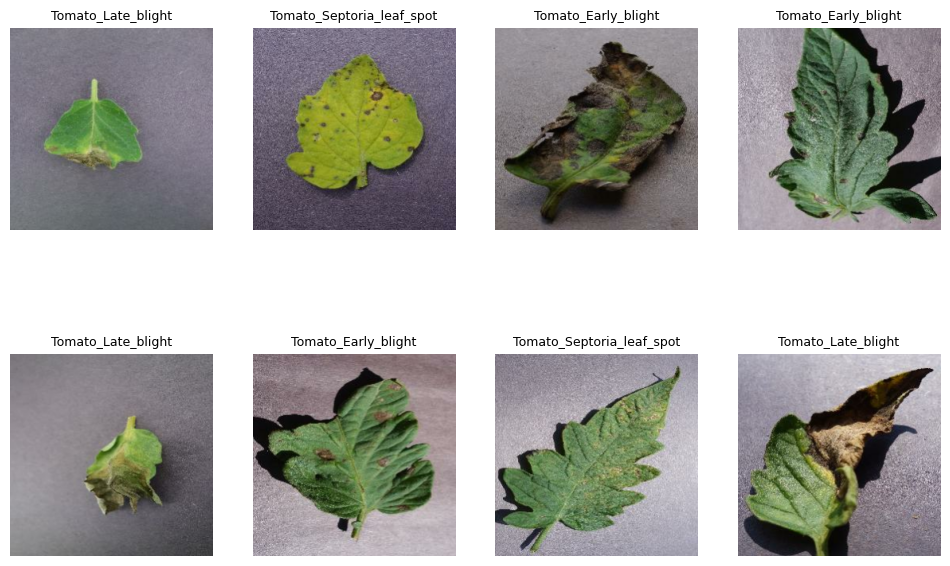

In [49]:
plt.figure(figsize=(12,12))
for image_batch,label_batch in dataset.take(1):
    for i in range(8):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]], fontsize=9)
        plt.axis("off")

In [50]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=10
model=models.Sequential([
    rescale_and_resize,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax")
])
model.build(input_shape=input_shape)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (40, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (40, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (40, 253, 253, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (40, 126, 126, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (40, 125, 125, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (40, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (40, 61, 61, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (40, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (40, 29, 29, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (40, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (40, 13, 13, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (40, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (40, 5, 5, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (40, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (40, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (40, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (40, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,042 (359.54 KB)

 Trainable params: 92,042 (359.54 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [53]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_ds
)

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 95s 730ms/step - accuracy: 0.3193 - loss: 1.5239 - val_accuracy: 0.4500 - val_loss: 1.2456
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 109s 851ms/step - accuracy: 0.5427 - loss: 1.0534 - val_accuracy: 0.6500 - val_loss: 0.9810
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 107s 835ms/step - accuracy: 0.6453 - loss: 0.8680 - val_accuracy: 0.6667 - val_loss: 0.7368
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 117s 906ms/step - accuracy: 0.7197 - loss: 0.7075 - val_accuracy: 0.6333 - val_loss: 0.7543
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 112s 873ms/step - accuracy: 0.7736 - loss: 0.5637 - val_accuracy: 0.7083 - val_loss: 0.6099
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 113s 884ms/step - accuracy: 0.7892 - loss: 0.5271 - val_accuracy: 0.7917 - val_loss: 0.5740
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 114s 877ms/step - accuracy: 0.8375 - loss: 0.4245 - val_accuracy: 0.7833 - val_loss: 0.5019
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 114s 892ms/step - accuracy: 0.8507 - 

In [58]:
scores= model.evaluate(testing_ds)
print(f"Test Accuracy: {scores[1]*100}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 353ms/step - accuracy: 0.9269 - loss: 0.2086
Test Accuracy: 92.67857074737549


In [59]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 126}

In [60]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [61]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]


Text(0.5, 1.0, 'Training and Validation loss')

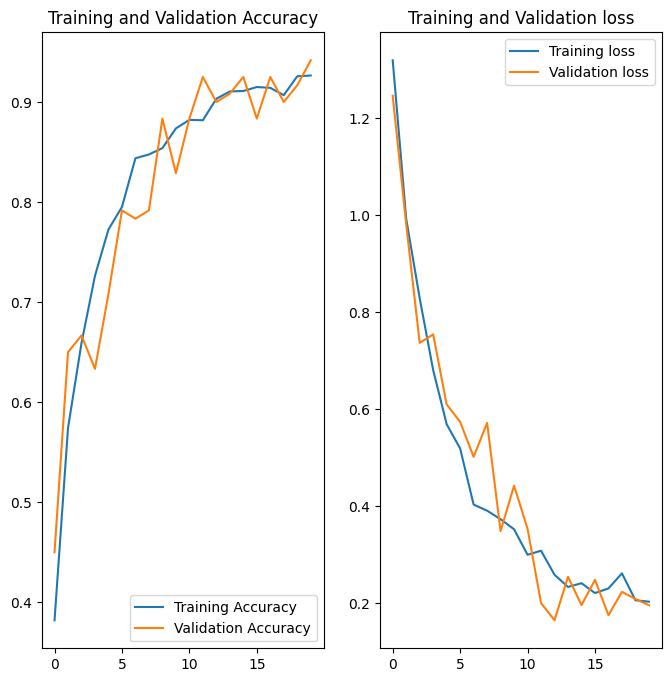

In [67]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2
            )
plt.plot(range(EPOCHS),loss,label="Training loss")
plt.plot(range(EPOCHS),val_loss,label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation loss")